### Import modules and packages. define functions

In [67]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns

from pyspark import SparkContext, SparkConf


%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

### Specify experiment directory, condtions and image details
#### Makes dictionary for later storage of results

In [25]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/Agg/' #master folder



In [90]:
early_channel_no=2 #channel number of early incubation colour
late_channel_no=1 #channel number of late incubation colour
synapse_channel_no=3

results = {"filename":[],
           "Early colour - spots mask":[],
           "Late colour - spots mask":[],
           "Synapse colour - spots mask":[],
           "exp condition":[],
           "Early colour - Raw mean intensity":[],
           "Late colour - Raw mean intensity":[],
           "Synapse colour - Raw mean intensity":[],
           "Mean correlation coefficient early/late":[],
           "Early colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Late colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Synapse colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Early colour - Total no. of spots in FOV":[],
           "Late colour - Total no. of spots in FOV":[],
           "Synapse colour - Total no. of spots in FOV":[],
           "Early colour - Mean spot area [nm]":[],
           "Late colour - Mean spot area [nm]":[],
           "Synapse colour - Mean spot area [nm]":[],
           "Early colour - masked by synapses":[],
           "Late colour - masked by synapses":[],
           "Mean colour bias of a pixel (early=-1<x<1=late)":[],
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)":[],
           "Early colour/Synapse colour corr (Mean intensity of spots)":[],
           "Late colour/Synapse colour corr (Mean intensity of spots)":[],
           "Mean colour bias of a pixel - shifted to pos values (early=0)":[],
           "Correlation between colour bias (0 shifted) and synapse intensity":[]}

synapse_results={"filename":[],
           "exp condition":[],
           "Early colour - Mean intensity":[], #based on spot segmentation
           "Late colour - Mean intensity":[],#based on spot segmentation
           "Synapse colour - Mean intensity":[],#based on spot segmentation
           "Synapse Area":[], 
           "Mean colour bias of synapse (early=-1<x<1=late)":[],
           "Is new synapse (1=new, 0=old)":[],
           "Correlation between late colour and synapse intensity":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if filelist[i].endswith(".nd2"): #& ("60x" in str(filelist[i]))==True:
        results["filename"].append(filelist[i])
        results["exp condition"].append(filelist[i].split('/')[-2])

In [69]:
results["exp condition"][0]

'FixedCtrl_OnlySecondColour'

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/Agg/1Day_Bic/20180501_Agg_08_002.nd2


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/Agg/FixedCtrl_FirstImmediatelySecond/20180501_Agg_02_001.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/Agg/1Day_Bic/20180501_Agg_08_007.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/Agg/Ctrl_Autofluorescence/20180501_Agg_12_006.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/Agg/LiveCtrl_OnlySecondColour/20180501_Agg_11_001.nd2


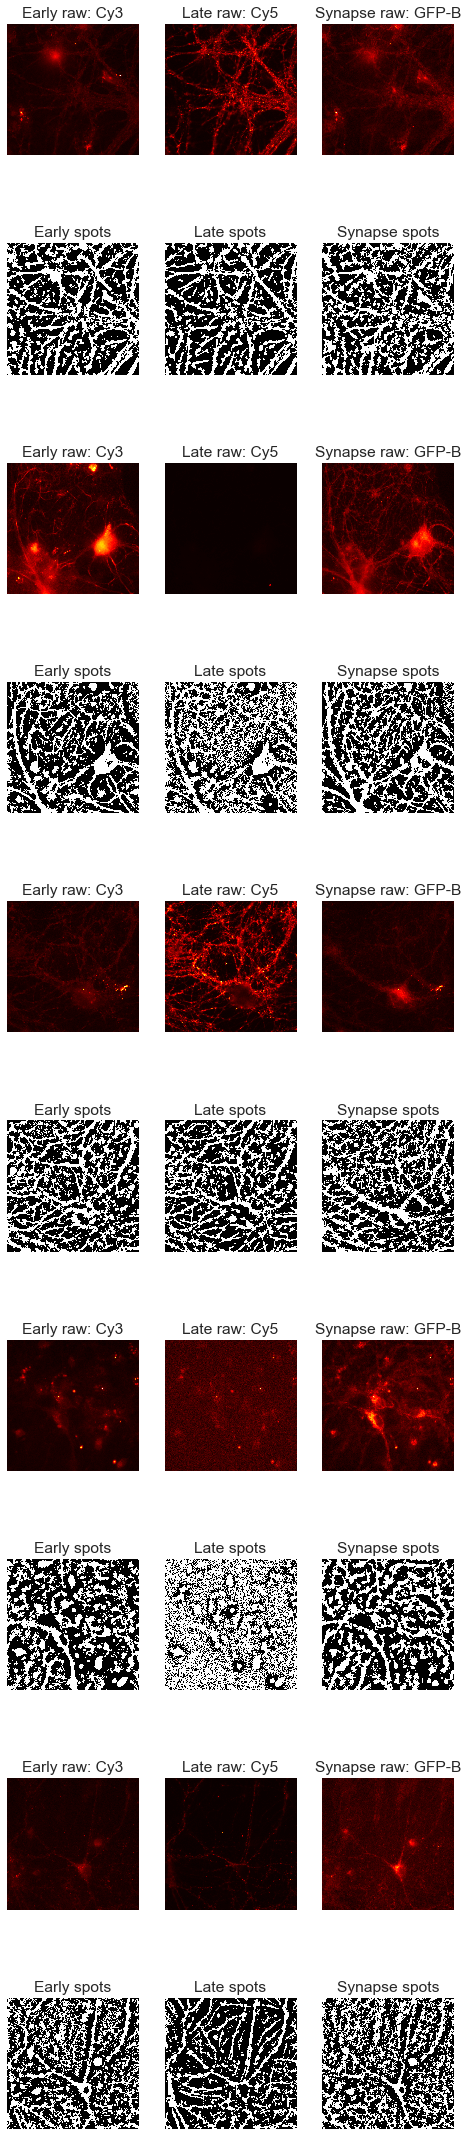

In [30]:
fig=plt.figure(figsize=(8,80))
figno=1
for im in range(0,5):
    im2read=results["filename"][np.random.randint(1,len(results["filename"]))]
    with ND2Reader(im2read) as images:
        print(im2read)
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
        [channel1name, channel2name, channel3name]=early_image.metadata['channels']
        if early_channel_no==2:
            early_channelname=channel2name
            late_channelname=channel1name
            synapse_channelname=channel3name
        else:
            early_channelname=channel1name
            late_channelname=channel2name
            synapse_channelname=channel3name

        #smoothing with gaussian filter for noise reduction
        #can play with sigma
        sigmagauss=1 #should be roughly half the size of the object you are detecting
        early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
        late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
        synapse_smooth=ndi.filters.gaussian_filter(synapse_image,sigmagauss)

        #adaptive thresholding - bg found by mean filter with SE
        i=51 #for SE
        struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2
        bg_early = rank.mean(early_smooth, selem=struct)
        bg_late = rank.mean(late_smooth, selem=struct)
        bg_synapse = rank.mean(synapse_smooth, selem=struct)
        early_spots = early_smooth >= bg_early
        late_spots = late_smooth >= bg_late
        synapse_spots = synapse_smooth >= bg_synapse
        #improve with binary hole filling
        #early_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(early_spots))
        #late_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(late_spots))
        #improve with binary closing
        #i2 = 3
        #struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
        #pad_size = i+2 #pad the spots image to avoid artifacts at the edges
        #padded_early_spots = np.pad(early_spots_holes_filled,pad_size,mode='reflect')
        #padded_late_spots = np.pad(late_spots_holes_filled,pad_size,mode='reflect')
        #early_spots_final = ndi.binary_closing(np.logical_not(padded_early_spots),structure=struct2)
        #late_spots_final = ndi.binary_closing(np.logical_not(padded_late_spots),structure=struct2)
        #remove the padding from before
        #early_spots_final = early_spots_final[pad_size:-pad_size,pad_size:-pad_size]
        #late_spots_final = late_spots_final[pad_size:-pad_size,pad_size:-pad_size]
            
        fig.add_subplot(20,3,figno)
        plt.imshow(early_image,interpolation='none',cmap='hot')
        plt.title('Early raw: '+early_channelname)
        plt.ylabel(im2read)
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.add_subplot(20,3,figno+1)
        plt.imshow(late_image,interpolation='none',cmap='hot')
        plt.title('Late raw: '+late_channelname)
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.add_subplot(20,3,figno+2)
        plt.imshow(synapse_image,interpolation='none',cmap='hot')
        plt.title('Synapse raw: '+synapse_channelname)
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.add_subplot(20,3,figno+3)
        plt.imshow(early_spots,interpolation='none',cmap='gray')
        plt.title('Early spots')
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.add_subplot(20,3,figno+4)
        plt.imshow(late_spots,interpolation='none',cmap='gray')
        plt.title('Late spots')
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.add_subplot(20,3,figno+5)
        plt.imshow(synapse_spots,interpolation='none',cmap='gray')
        plt.title('Synapse spots')
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        figno=figno+6

### Visualize the colour bias image

In [11]:
im2read=results["filename"][70]
with ND2Reader(im2read) as images:
    print(im2read)
    early_image=images[early_channel_no-1]
    late_image=images[late_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    [channel1name, channel2name, channel3name]=early_image.metadata['channels']

early_image=early_image_raw.astype(np.int16)
late_image=late_image_raw.astype(np.int16)
synapse_image=synapse_image_raw.astype(np.int16)
early_spots=results["Early colour - spots mask"][70]

#subtract autofluorescence in each channel
early_image=early_image-early_autoint_mean
early_image[early_image<0]=0
late_image=late_image-late_autoint_mean
late_image[late_image<0]=0
synapse_image=synapse_image-synapse_autoint_mean
synapse_image[synapse_image<0]=0
#normalize intensity to value between 0 and 1
early_image=np.divide(early_image,16383.)
late_image=np.divide(late_image,16383.)
synapse_image=np.divide(synapse_image,16383.)

print(early_image.shape)
imagenew=np.divide(late_image-early_image,late_image+early_image)
imagenew.shape
imagenew[~early_spots]=0

#early_image_new=early_image_raw
#early_image_new[~early_spots]=0

fig=plt.figure(figsize=(10,10))
fig.add_subplot(3,2,1)
plt.imshow(imagenew,interpolation=None,cmap='coolwarm')
plt.colorbar()
plt.title('Eccentricity')
fig.add_subplot(3,2,3)
plt.imshow(early_image_raw,interpolation=None,cmap='gray')
plt.colorbar()
plt.title('Early image raw')
fig.add_subplot(3,2,4)
plt.imshow(early_image,interpolation=None,cmap='gray')
plt.colorbar()
plt.title('Early image auto subtracted normd')
fig.add_subplot(3,2,5)
plt.imshow(late_image_raw,interpolation=None,cmap='gray')
plt.colorbar()
plt.title('Late image raw')
fig.add_subplot(3,2,6)
plt.imshow(early_image,interpolation=None,cmap='gray')
plt.colorbar()
plt.title('Late image auto subtracted normd')
        

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second/TNR/1DayTTX/20180501_TNR_09_011.nd2


NameError: name 'early_image_raw' is not defined

In [ ]:
new=early_image+late_image
imagenew[new==0]=1

In [ ]:
plt.imshow(new)
plt.colorbar()
plt.show()

#### After optimizing, run below to make segmentation masks for all images

In [91]:
for im in range(0,len(results["filename"])): 
    with ND2Reader(results["filename"][im]) as images:
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            synapse_image=images[synapse_channel_no-1]
            
            #smoothing with gaussian filter for noise reduction
            #can play with sigma
            # sigmagauss=3 #taken from previous cell
            early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
            late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
            synapse_smooth = ndi.filters.gaussian_filter(synapse_image,sigmagauss)
            early_image=np.divide(early_image,16383.)
            late_image=np.divide(late_image,16383.)
            synapse_image=np.divide(synapse_image,16383.)
            
            #adaptive thresholding - bg found by mean filter with SE
            #i=31 #for SE - taken from previous cell
            struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2
            bg_early = rank.mean(early_smooth, selem=struct)
            bg_late = rank.mean(late_smooth, selem=struct)
            bg_synapse = rank.mean(synapse_smooth, selem=struct)
            early_spots = early_smooth >= bg_early
            late_spots = late_smooth >= bg_late
            synapse_spots = synapse_smooth >= bg_synapse
            #improve with binary hole filling
            #early_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(early_spots))
            #late_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(late_spots))
            #improve with binary closing
            #i2 = 3
            #struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
            #pad_size = i+2 #pad the spots image to avoid artifacts at the edges
            #padded_early_spots = np.pad(early_spots_holes_filled,pad_size,mode='reflect')
            #padded_late_spots = np.pad(late_spots_holes_filled,pad_size,mode='reflect')
            #early_spots_final = ndi.binary_closing(np.logical_not(padded_early_spots),structure=struct2)
            #late_spots_final = ndi.binary_closing(np.logical_not(padded_late_spots),structure=struct2)
            #remove the padding from before
            #early_spots_final = early_spots_final[pad_size:-pad_size,pad_size:-pad_size]
            #late_spots_final = late_spots_final[pad_size:-pad_size,pad_size:-pad_size]
            
            results["Early colour - spots mask"].append(early_spots)
            results["Late colour - spots mask"].append(late_spots)
            results["Synapse colour - spots mask"].append(late_spots)

/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


In [92]:
#calculate the mean autofluorescence in each channel for later subtraction
lookuplist=[('filename',results["filename"]),('exp condition',results["exp condition"])] 
lookupdf = pd.DataFrame.from_items(lookuplist)
#no_images=len(lookupdf[lookupdf["exp condition"]=="fixedctrl_nocolours"])

earlybg_filelist=lookupdf[lookupdf["exp condition"]=="Ctrl_Autofluorescence"]
latebg_filelist=lookupdf[lookupdf["exp condition"]=="Ctrl_Autofluorescence"]
synapsebg_filelist=lookupdf[lookupdf["exp condition"]=="Ctrl_Autofluorescence"]


no_images_earlybg=len(lookupdf[lookupdf["exp condition"]=="Ctrl_Autofluorescence"])
no_images_latebg=len(lookupdf[lookupdf["exp condition"]=="Ctrl_Autofluorescence"])
no_images_synapsebg=len(lookupdf[lookupdf["exp condition"]=="Ctrl_Autofluorescence"])


                      
earlycolour_autoint=np.zeros((no_images_earlybg,1))
latecolour_autoint=np.zeros((no_images_latebg,1))
synapsecolour_autoint=np.zeros((no_images_synapsebg,1))


for i in range(0,no_images_earlybg):
    with ND2Reader(earlybg_filelist.iloc[i]["filename"]) as images:
        early_image=images[early_channel_no-1]
        early_image=ndi.filters.median_filter(early_image,size=(3,3))
        earlycolour_autoint[i]=np.mean(early_image)
for i in range(0,no_images_latebg):
    with ND2Reader(latebg_filelist.iloc[i]["filename"]) as images:
        late_image=images[late_channel_no-1]
        late_image=ndi.filters.median_filter(late_image,size=(3,3))
        latecolour_autoint[i]=np.mean(late_image)
for i in range(0,no_images_synapsebg):
    with ND2Reader(synapsebg_filelist.iloc[i]["filename"]) as images:
        synapse_image=images[synapse_channel_no-1]
        synapse_image=ndi.filters.median_filter(synapse_image,size=(3,3))
        synapsecolour_autoint[i]=np.mean(synapse_image)
        
early_autoint_mean=np.mean(earlycolour_autoint)
late_autoint_mean=np.mean(latecolour_autoint)
synapse_autoint_mean=np.mean(synapsecolour_autoint)

print(early_autoint_mean)
print(late_autoint_mean)
print(synapse_autoint_mean)

1397.829664993286
124.40568389892579
750.0807521820068


In [ ]:
#if no controls done - run this
early_autoint_mean=0
late_autoint_mean=0
synapse_autoint_mean=0

### Batch analyse images, after creating the segmentation masks

In [93]:
for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i) + 'out of' + str(len(results["filename"])))
    with ND2Reader(results["filename"][i]) as images:
            #read the images
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            synapse_image=images[synapse_channel_no-1]
            #medfilt 
            early_image=ndi.filters.median_filter(early_image,size=(3,3))
            late_image=ndi.filters.median_filter(late_image,size=(3,3))
            synapse_image=ndi.filters.median_filter(synapse_image,size=(3,3))
            #convert to array
            early_image=early_image.astype(np.int16)
            late_image=late_image.astype(np.int16)
            synapse_image=synapse_image.astype(np.int16)
            #subtract autofluorescence in each channel
            early_image=early_image-early_autoint_mean
            early_image[early_image<0]=0
            late_image=late_image-late_autoint_mean
            late_image[late_image<0]=0
            synapse_image=synapse_image-synapse_autoint_mean
            synapse_image[synapse_image<0]=0
            #normalize intensity to value between 0 and 1
            early_image=np.divide(early_image,16383.)
            late_image=np.divide(late_image,16383.)
            synapse_image=np.divide(synapse_image,16383.)
            #read spots masks
            early_spots=results["Early colour - spots mask"][i]
            late_spots=results["Late colour - spots mask"][i]
            synapse_spots=results["Synapse colour - spots mask"][i]
            #label the spots
            spots_early_labels,_ = ndi.label(early_spots)
            spots_late_labels,_ = ndi.label(late_spots)
            spots_synapse_labels,_ = ndi.label(synapse_spots)
            #calculate results
            early_spots_intensities=np.zeros((len(np.unique(spots_early_labels)),1))
            early_spots_areas=np.zeros((len(np.unique(spots_early_labels)),1))
            late_spots_intensities=np.zeros((len(np.unique(spots_late_labels)),1))
            late_spots_areas=np.zeros((len(np.unique(spots_late_labels)),1))
            synapse_spots_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))
            synapse_spots_areas=np.zeros((len(np.unique(spots_synapse_labels)),1))
            
            early_atsynapses_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))   
            late_atsynapses_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))   
            
            spots_late_minus_early_int=np.zeros((len(np.unique(spots_early_labels)),1))
            spots_late_minus_early_atsynapses_int=np.zeros((len(np.unique(spots_synapse_labels)),1))
            
            for spotno in np.unique(spots_early_labels)[1:]:
                early_spots_mask = spots_early_labels==spotno
                early_spots_intensities[(spotno)]=np.mean(early_image[early_spots_mask])
                early_spots_areas[spotno]=np.sum(early_spots_mask)
                
                a=late_image[early_spots_mask]
                b=early_image[early_spots_mask]
                spots_late_minus_early_int[spotno]=np.mean(np.divide([a-b],[a+b]))
                    
            for spotnol in np.unique(spots_late_labels)[1:]:
                late_spots_mask= spots_late_labels==spotnol
                late_spots_intensities[spotnol]=np.mean(late_image[late_spots_mask])
                late_spots_areas[spotnol]=np.sum(late_spots_mask)
                
            for spotnos in np.unique(spots_synapse_labels)[1:]:
                synapse_spots_mask= spots_synapse_labels==spotnos
                synapse_spots_intensities[spotnos]=np.mean(synapse_image[synapse_spots_mask])
                synapse_spots_areas[spotnos]=np.sum(synapse_spots_mask)
                
                early_atsynapses_intensities=np.mean(early_image[synapse_spots_mask])
                late_atsynapses_intensities=np.mean(late_image[synapse_spots_mask])
                
                synapse_results["filename"].append(results["filename"][i])
                synapse_results["exp condition"].append(results["exp condition"][i])
                synapse_results["Early colour - Mean intensity"].append(early_atsynapses_intensities)
                synapse_results["Late colour - Mean intensity"].append(late_atsynapses_intensities)
                synapse_results["Synapse colour - Mean intensity"].append(np.mean(synapse_image[synapse_spots_mask]))
                
                eccentricity=np.divide([late_atsynapses_intensities-early_atsynapses_intensities],[late_atsynapses_intensities+early_atsynapses_intensities])
                synapse_results["Mean colour bias of synapse (early=-1<x<1=late)"].append(eccentricity)
                if eccentricity > 0.8:
                    synapse_results["Is new synapse (1=new, 0=old)"].append('1')
                else:
                    synapse_results["Is new synapse (1=new, 0=old)"].append('0')  
                
                a=late_image[synapse_spots_mask]
                b=early_image[synapse_spots_mask]
                spots_late_minus_early_atsynapses_int[spotnos]=np.mean(np.divide([a-b],[a+b]))
                
            
            #result calculation:
            
            #results based on spot segmentation    
            results["Early colour - Mean intensity of spots"].append(np.mean(early_spots_intensities))
            results["Late colour - Mean intensity of spots"].append(np.mean(late_spots_intensities))
            results["Synapse colour - Mean intensity of spots"].append(np.mean(synapse_spots_intensities))

            results["Early colour - Total no. of spots in FOV"].append(len(early_spots_intensities))
            results["Late colour - Total no. of spots in FOV"].append(len(late_spots_intensities))
            results["Synapse colour - Total no. of spots in FOV"].append(len(synapse_spots_intensities))
            
            results["Early colour - Mean spot area [nm]"].append(np.mean(early_spots_areas))
            results["Late colour - Mean spot area [nm]"].append(np.mean(late_spots_areas))
            results["Synapse colour - Mean spot area [nm]"].append(np.mean(synapse_spots_areas))

            results["Early colour - masked by synapses"].append(np.mean(early_atsynapses_intensities))
            results["Late colour - masked by synapses"].append(np.mean(late_atsynapses_intensities))
            results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)"].append(np.mean(spots_late_minus_early_int))

            late_minus_early=np.divide([late_image-early_image],[late_image+early_image])
            pos_late_minus_early=late_minus_early
            pos_late_minus_early=np.add(pos_late_minus_early,(-1*np.min(pos_late_minus_early)))
            #results["Correlation between colour bias and synapse intensity"].append(corr2(pos_late_minus_early,synapse_image))
            
            #global results
            results["Early colour - Raw mean intensity"].append(np.mean(early_image))
            results["Late colour - Raw mean intensity"].append(np.mean(late_image))
            results["Synapse colour - Raw mean intensity"].append(np.mean(synapse_image))
            results["Mean correlation coefficient early/late"].append(corr2(early_image,late_image))
            results["Mean colour bias of a pixel (early=-1<x<1=late)"].append(np.mean(spots_late_minus_early_int))
            results["Mean colour bias of a pixel - shifted to pos values (early=0)"].append(np.mean(results["Mean colour bias of a pixel (early=-1<x<1=late)"]+max(results["Mean colour bias of a pixel (early=-1<x<1=late)"])))
            results["Correlation between colour bias (0 shifted) and synapse intensity"].append(corr2(pos_late_minus_early,synapse_image))
            results["Early colour/Synapse colour corr (Mean intensity of spots)"].append(corr2(early_image,synapse_image))
            results["Late colour/Synapse colour corr (Mean intensity of spots)"].append(corr2(late_image,synapse_image))
    

Calculating image no 0out of154


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Calculating image no 1out of154
Calculating image no 2out of154
Calculating image no 3out of154
Calculating image no 4out of154
Calculating image no 5out of154
Calculating image no 6out of154
Calculating image no 7out of154
Calculating image no 8out of154
Calculating image no 9out of154
Calculating image no 10out of154
Calculating image no 11out of154
Calculating image no 12out of154
Calculating image no 13out of154
Calculating image no 14out of154
Calculating image no 15out of154
Calculating image no 16out of154
Calculating image no 17out of154
Calculating image no 18out of154
Calculating image no 19out of154
Calculating image no 20out of154
Calculating image no 21out of154
Calculating image no 22out of154
Calculating image no 23out of154
Calculating image no 24out of154
Calculating image no 25out of154
Calculating image no 26out of154
Calculating image no 27out of154
Calculating image no 28out of154
Calculating image no 29out of154
Calculating image no 30out of154
Calculating image n

### Make a clean figure of an experimental condition, with merged image and scalebar

In [ ]:
experimental_condition_to_display='1 day' #'1 day' or '1 day + bic'

medfiltarray=[3,3] #play with med filter size

fig=plt.figure(figsize=(10,100))
no_of_ims_in_condition = sum( x == experimental_condition_to_display for x in results["exp condition"] )
print(no_of_ims_in_condition)
counter=1

for i in range(0,len(results["filename"])): 
    if (results["exp condition"][i]==experimental_condition_to_display and counter<15):
        
        with ND2Reader(results["filename"][i]) as images:
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            
            #some basic preprocessing: smoothing (noise reduction) with med filter, and contrast adjustment
            early_smoothed=ndi.filters.median_filter(early_image,medfiltarray)
            v_min1, v_max1 = np.percentile(early_smoothed, (0.2, 99.8))
            early_smoothed_adjusted=exposure.rescale_intensity(early_smoothed, in_range=(v_min1, v_max1))
            late_smoothed=ndi.filters.median_filter(late_image,medfiltarray)
            v_min2, v_max2 = np.percentile(late_smoothed, (0.2, 99.8))
            late_smoothed_adjusted=exposure.rescale_intensity(late_smoothed, in_range=(v_min2, v_max2))
            
            #make early image green and late image red
            greencmap = clr.LinearSegmentedColormap.from_list('customred', ['#000000','#06C420'], N=256)
            redcmap=clr.LinearSegmentedColormap.from_list('customred', ['#000000','#FD0120'], N=256)

            normearly = early_smoothed_adjusted.astype(np.float32) # convert to float
            normearly -= normearly.min() # ensure the minimal value is 0.0
            normearly /= normearly.max() # maximum value in image is now 1.0
            normlate = late_smoothed_adjusted.astype(np.float32) # convert to float
            normlate -= normlate.min() # ensure the minimal value is 0.0
            normlate /= normlate.max() # maximum value in image is now 1.0
            
            early_ingreen=greencmap(normearly)
            late_inred=redcmap(normlate)
            
            #make composite with a scalebar
            comp=Image.blend(toimage(early_ingreen),toimage(late_inred),0.5)
            micronsperpixel=early_image.metadata['pixel_microns']
            scalebar = ScaleBar(dx=micronsperpixel,units='um',color='white',length_fraction=0.16,bar_color='none') # 1 pixel = 0.2 meter
            
            fig.add_subplot(no_of_ims_in_condition,3,counter)
            plt.imshow(early_ingreen,interpolation='none')
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
            plt.gca().set_aspect('equal')
            plt.gca().grid(color='none')

            fig.add_subplot(no_of_ims_in_condition,3,(counter+1))
            plt.imshow(late_inred,interpolation='none')
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
            plt.gca().set_aspect('equal')
            plt.gca().grid(color='none')
            
            fig.add_subplot(no_of_ims_in_condition,3,(counter+2))
            plt.imshow(comp)
            plt.gca().add_artist(scalebar)
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
            plt.gca().set_aspect('equal')
            plt.gca().grid(color='none')
            
            counter=counter+3
            
plt.subplots_adjust(wspace=0, hspace=0)

### Plots

In [64]:
results["Mean colour bias of a pixel (early=-1<x<1=late)"]=results["Mean colour bias of a pixel (early=-1<x<1=late)"][:-1]

In [78]:
results["Mean colour bias of a pixel - shifted to pos values (early=0)"]

[array([nan]),
 array([nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, 

In [94]:
df=pd.DataFrame(results)
df.to_csv(path_or_buf=expdir+'results.csv')

In [13]:
df=pd.read_csv(expdir+'results.csv')

In [95]:
df_corrected=df

In [14]:
df_corrected['Mean colour bias shifted to 0']=df_corrected['Mean colour bias of a pixel (early=-1<x<1=late)']

In [21]:
df_corrected['Mean colour bias shifted to 0']=df_corrected['Mean colour bias shifted to 0']+df_corrected['Mean colour bias shifted to 0'].max()

In [96]:
df_corrected

,Correlation between colour bias (0 shifted) and synapse intensity,Early colour - Mean intensity of spots,Early colour - Mean spot area [nm],Early colour - Raw mean intensity,Early colour - Total no. of spots in FOV,Early colour - masked by synapses,Early colour - spots mask,Early colour/Synapse colour corr (Mean intensity of spots),Late colour - Mean intensity of spots,Late colour - Mean spot area [nm],...,Mean colour bias of a pixel - shifted to pos values (early=0),"Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)",Mean correlation coefficient early/late,Synapse colour - Mean intensity of spots,Synapse colour - Mean spot area [nm],Synapse colour - Raw mean intensity,Synapse colour - Total no. of spots in FOV,Synapse colour - spots mask,exp condition,filename
0,NaN,0.000213,309.551370,0.001994,292,0.000000,"[[True, True, True, True, True, True, True, Tr...",0.584741,0.000494,77.071027,...,NaN,NaN,0.872925,0.010310,77.071027,0.025265,1422,"[[True, True, True, True, True, True, True, Tr...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
1,NaN,0.002119,150.797595,0.005355,499,0.000000,"[[False, False, False, False, False, False, Fa...",0.602921,0.001033,85.215116,...,NaN,NaN,0.739977,0.013034,85.215116,0.029500,1376,"[[False, False, False, False, False, False, Fa...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
2,NaN,0.000007,108.366071,0.000111,896,0.000000,"[[False, False, True, True, True, True, True, ...",0.237442,0.000507,104.540373,...,NaN,NaN,0.190716,0.005794,104.540373,0.009829,1288,"[[True, False, False, True, True, True, True, ...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
3,NaN,0.000289,185.153333,0.001700,450,0.000000,"[[False, False, False, False, True, True, True...",0.493615,0.000700,73.326726,...,NaN,NaN,0.601146,0.009686,73.326726,0.020299,1564,"[[False, True, True, True, True, True, True, F...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
4,NaN,0.000038,199.124169,0.001313,451,0.000000,"[[False, False, False, False, False, False, Fa...",0.651844,0.000529,69.609102,...,NaN,NaN,0.846281,0.007901,69.609102,0.019826,1604,"[[False, False, False, False, False, False, Fa...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
5,NaN,0.000144,167.446069,0.001317,547,0.000000,"[[False, False, False, False, False, False, Fa...",0.483758,0.000892,86.509531,...,NaN,NaN,0.584259,0.008299,86.509531,0.017887,1364,"[[True, True, True, False, False, True, True, ...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
6,NaN,0.001751,251.944954,0.004445,327,0.000000,"[[False, False, False, False, False, False, Fa...",0.711882,0.001075,101.833333,...,NaN,NaN,0.666114,0.012446,101.833333,0.026377,1098,"[[True, True, True, True, False, False, False,...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
7,NaN,0.000603,205.450135,0.003113,371,0.000000,"[[False, False, False, False, False, False, Tr...",0.647830,0.000790,71.707664,...,NaN,NaN,0.724095,0.003323,71.707664,0.015439,1618,"[[False, False, False, False, False, False, Tr...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
8,NaN,0.001609,163.451546,0.008175,485,0.000000,"[[False, False, False, False, False, False, Fa...",0.908124,0.000870,85.697227,...,NaN,NaN,0.859410,0.009973,85.697227,0.031958,1298,"[[True, True, True, False, False, False, False...",FixedCtrl_OnlySecondColour,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...
9,NaN,0.058937,258.748387,0.060672,310,0.050734,"[[False, False, False, False, False, False, Fa...",0.835204,0.001131,80.524604,...,NaN,-0.948699,0.315884,0.011015,80.524604,0.019795,1199,"[[False, False, False, False, False, False, Fa...",FixedCtrl_FirstImmediatelySecond,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/C...


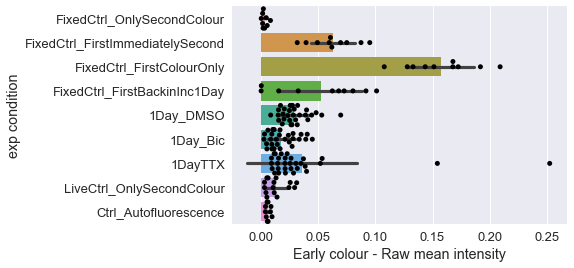

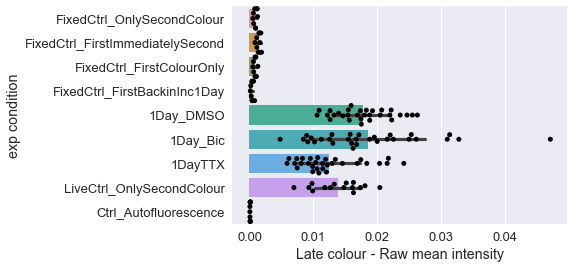

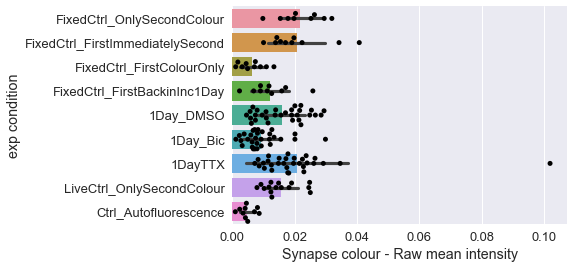

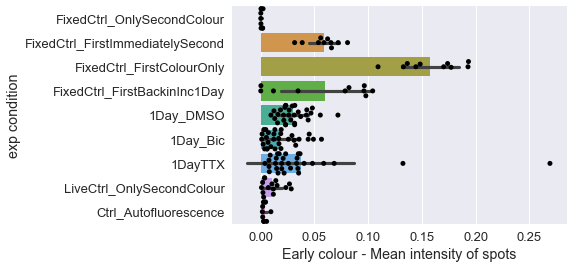

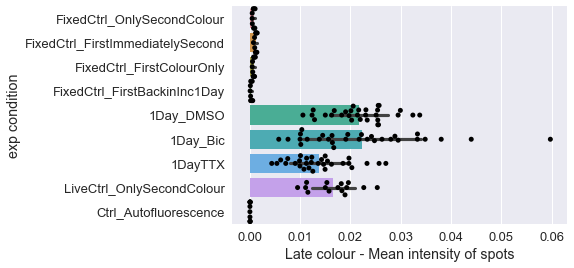

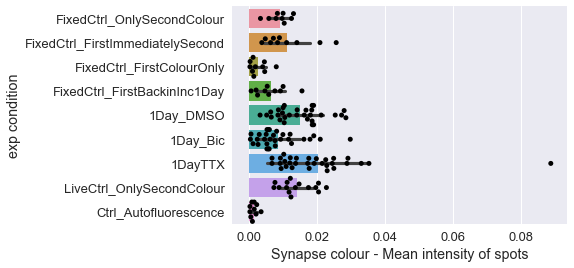

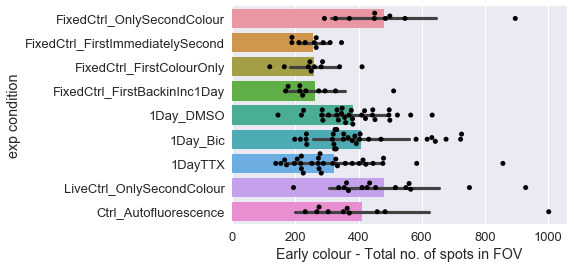

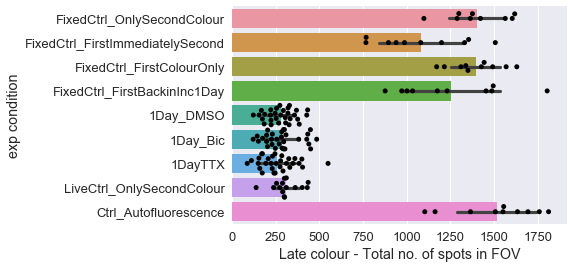

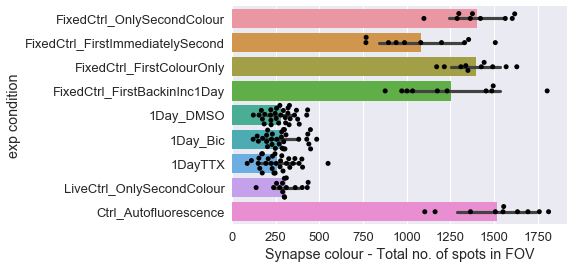

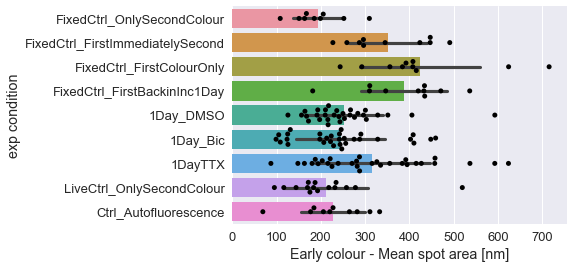

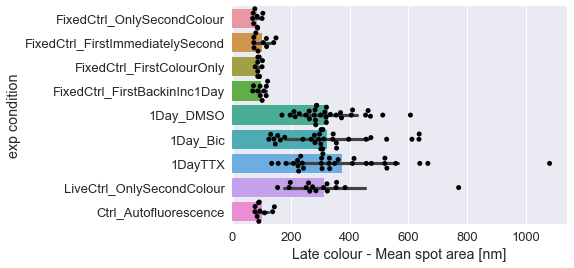

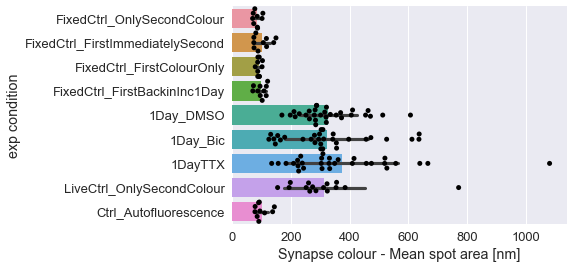

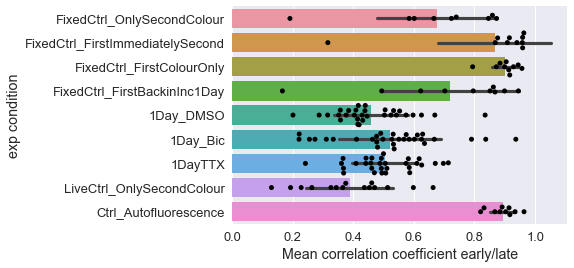

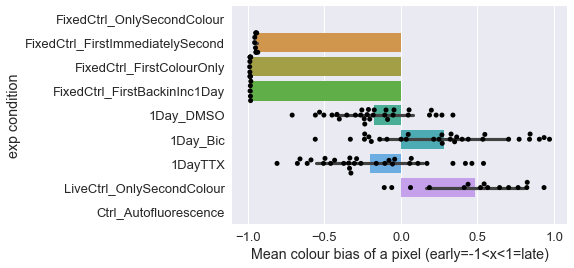

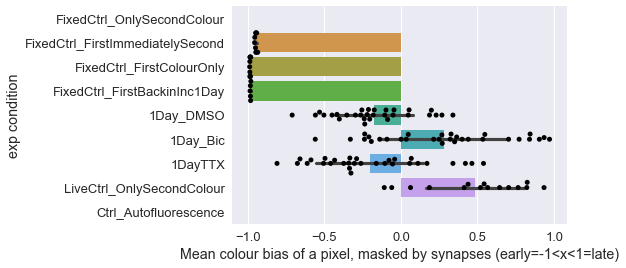

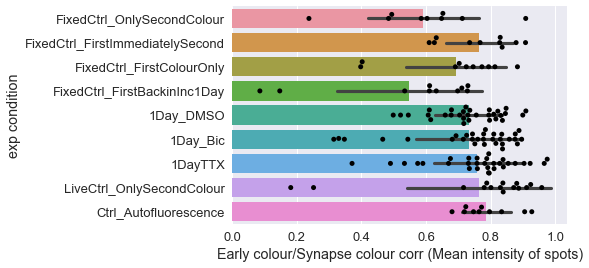

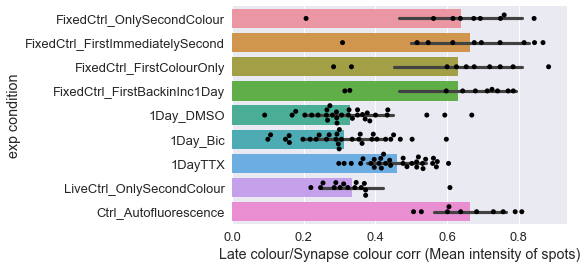

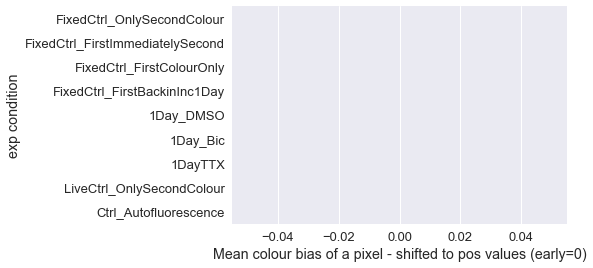

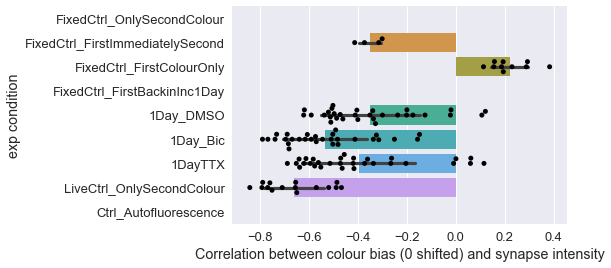

In [98]:
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(x="Early colour - Raw mean intensity", y="exp condition",data=df_corrected,ci='sd')
d=sns.swarmplot(x="Early colour - Raw mean intensity", y="exp condition",data=df_corrected,color='black')
fig1.savefig(expdir+'plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.barplot(x='Late colour - Raw mean intensity', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Raw mean intensity", y="exp condition",data=df_corrected,color='black')
fig2.savefig(expdir+'plot2.png',bbox_inches='tight')

fig2_=plt.figure()
d=sns.barplot(x='Synapse colour - Raw mean intensity', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Synapse colour - Raw mean intensity", y="exp condition",data=df_corrected,color='black')
fig2_.savefig(expdir+'plot2_.png',bbox_inches='tight')

fig3=plt.figure()
d=sns.barplot(x='Early colour - Mean intensity of spots', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour - Mean intensity of spots", y="exp condition",data=df_corrected,color='black')
fig3.savefig(expdir+'plot3.png',bbox_inches='tight')

fig4=plt.figure()
d=sns.barplot(x='Late colour - Mean intensity of spots', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Mean intensity of spots", y="exp condition",data=df_corrected,color='black')
fig4.savefig(expdir+'plot4.png',bbox_inches='tight')

fig4_=plt.figure()
d=sns.barplot(x='Synapse colour - Mean intensity of spots', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Synapse colour - Mean intensity of spots", y="exp condition",data=df_corrected,color='black')
fig4_.savefig(expdir+'plot4_.png',bbox_inches='tight')


fig5=plt.figure()
d=sns.barplot(x='Early colour - Total no. of spots in FOV', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour - Total no. of spots in FOV", y="exp condition",data=df_corrected,color='black')
fig5.savefig(expdir+'plot5.png',bbox_inches='tight')

fig6=plt.figure()
d=sns.barplot(x='Late colour - Total no. of spots in FOV', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Total no. of spots in FOV", y="exp condition",data=df_corrected,color='black')
fig6.savefig(expdir+'plot6.png',bbox_inches='tight')

fig6_=plt.figure()
d=sns.barplot(x='Synapse colour - Total no. of spots in FOV', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Synapse colour - Total no. of spots in FOV", y="exp condition",data=df_corrected,color='black')
fig6_.savefig(expdir+'plot6_.png',bbox_inches='tight')

fig7=plt.figure()
d=sns.barplot(x='Early colour - Mean spot area [nm]', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour - Mean spot area [nm]", y="exp condition",data=df_corrected,color='black')
fig7.savefig(expdir+'plot7.png',bbox_inches='tight')

fig8=plt.figure()
d=sns.barplot(x='Late colour - Mean spot area [nm]', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Mean spot area [nm]", y="exp condition",data=df_corrected,color='black')
fig8.savefig(expdir+'plot8.png',bbox_inches='tight')

fig8_=plt.figure()
d=sns.barplot(x='Synapse colour - Mean spot area [nm]', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Synapse colour - Mean spot area [nm]", y="exp condition",data=df_corrected,color='black')
fig8_.savefig(expdir+'plot8_.png',bbox_inches='tight')

fig9=plt.figure()
d=sns.barplot(x='Mean correlation coefficient early/late', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Mean correlation coefficient early/late", y="exp condition",data=df_corrected,color='black')
fig9.savefig(expdir+'plot9.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Mean colour bias of a pixel (early=-1<x<1=late)", y="exp condition",data=df_corrected,color='black')
fig10.savefig(expdir+'plot10.png',bbox_inches='tight')

fig11=plt.figure()
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)", y="exp condition",data=df_corrected,color='black')
fig11.savefig(expdir+'plot11.png',bbox_inches='tight')

#fig12=plt.figure()
#d=sns.barplot(x='Correlation between colour bias and synapse intensity', y='exp condition',data=df_corrected, ci='sd')
#d=sns.swarmplot(x="Correlation between colour bias and synapse intensity", y="exp condition",data=df_corrected,color='black')
#fig12.savefig(expdir+'plot12.png',bbox_inches='tight')

fig13=plt.figure()
d=sns.barplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour/Synapse colour corr (Mean intensity of spots)", y="exp condition",data=df_corrected,color='black')
fig13.savefig(expdir+'plot13.png',bbox_inches='tight')

fig14=plt.figure()
d=sns.barplot(x="Late colour/Synapse colour corr (Mean intensity of spots)", y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour/Synapse colour corr (Mean intensity of spots)", y="exp condition",data=df_corrected,color='black')
fig14.savefig(expdir+'plot14.png',bbox_inches='tight')

fig15=plt.figure()
d=sns.barplot(x="Mean colour bias of a pixel - shifted to pos values (early=0)", y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Mean colour bias of a pixel - shifted to pos values (early=0)", y="exp condition",data=df_corrected,color='black')
fig15.savefig(expdir+'plot15.png',bbox_inches='tight')

fig16=plt.figure()
d=sns.barplot(x="Correlation between colour bias (0 shifted) and synapse intensity", y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x= "Correlation between colour bias (0 shifted) and synapse intensity", y="exp condition",data=df_corrected,color='black')
fig16.savefig(expdir+'plot16.png',bbox_inches='tight')



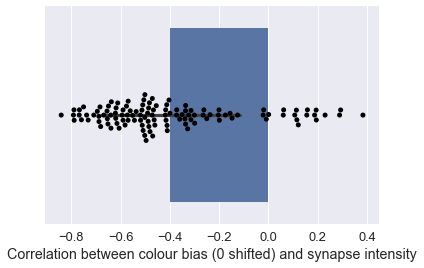

In [99]:
fig16=plt.figure()
d=sns.barplot(x="Correlation between colour bias (0 shifted) and synapse intensity", data=df_corrected, ci='sd')
d=sns.swarmplot(x= "Correlation between colour bias (0 shifted) and synapse intensity", data=df_corrected,color='black')

In [ ]:
df_corrected[df_corrected['exp condition'].isin(['1Day_DMSO', '1Day_Bic', '1Day_TTX'])]['Correlation between colour bias and synapse intensity'].mean()


In [ ]:
df_corrected[df_corrected['exp condition'].isin(['1Day_DMSO'])]['Mean colour bias of a pixel (early=-1<x<1=late)']



In [ ]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.plot(x='exp condition', y='Early colour - Mean intensity of spots',kind='bar', color='red', ax=ax, width=width, position=1)
df.plot(x='exp condition', y='Late colour - Mean intensity of spots',kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Early spots int')
ax2.set_ylabel('Late spots int')

plt.show()






In [ ]:
df_means=df.groupby('exp condition').mean()

In [ ]:
df_means['Late - early spot int']=df_means['Late colour - Mean intensity of spots']


In [ ]:
df_means['Late - early spot int']=df_means['Late - early spot int'].sub(df_means['Early colour - Mean intensity of spots'],axis=0)

In [ ]:
fig=plt.figure()
df_means.plot(y='Late - early spot int',kind='bar', color='red')



In [ ]:
expdir='/Users/taldankovich/Documents/BicTurnover_180130/'
dfnew=pd.read_json(path_or_buf=expdir+'results.json')

In [ ]:
results["Mean colour bias of a pixel (early=-1<x<1=late)"]

In [ ]:
dfbics=df[df["exp condition"].isin(['1Day', '1DayBic','2Day', '2DayBic','3Day', '3DayBic'])]

In [ ]:
fig10=plt.figure()
d=sns.violinplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_correctedbics, ci='sd')

In [ ]:
dfbics[dfbics['exp condition']=='day 3']

In [27]:
syn=synapse_results
del syn["Synapse Area"]

In [28]:
df_synapses=pd.DataFrame(syn)

ValueError: arrays must all be same length

In [ ]:
del syn["Correlation between late colour and synapse intensity"]

In [ ]:
df_synapses=pd.DataFrame(syn)
df_synapses.to_csv(path_or_buf=expdir+'results_synapses.csv')

In [ ]:
df_synapses=pd.read_csv(expdir+'results_synapses.csv')

In [ ]:
df_synapses["Is new synapse (1=new, 0=old)"]=df_synapses["Is new synapse (1=new, 0=old)"].astype(np.float)
df_synapses["Mean colour bias of synapse (early=-1<x<1=late)"]=df_synapses["Mean colour bias of synapse (early=-1<x<1=late)"].astype(np.float)

In [ ]:
df_synapses["Mean colour bias of synapse (early=-1<x<1=late)"]

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(x="Early colour - Mean intensity", y="exp condition",data=df_synapses,ci='sd')
#d=sns.swarmplot(x="Early colour - Mean intensity", y="exp condition",data=df_synapses,color='black')
fig1.savefig('plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.barplot(x='Late colour - Mean intensity', y='exp condition',data=df_synapses, ci='sd')
#d=sns.swarmplot(x="Late colour - Mean intensity", y="exp condition",data=df_synapses,color='black')
fig2.savefig('plot2.png',bbox_inches='tight')

fig2_=plt.figure()
d=sns.barplot(x='Synapse colour - Mean intensity', y='exp condition',data=df_synapses, ci='sd')
#d=sns.swarmplot(x="Synapse colour - Mean intensity", y="exp condition",data=df_synapses,color='black')
fig2_.savefig('plot2_.png',bbox_inches='tight')


fig4=plt.figure()
d=sns.barplot(x='Mean colour bias of synapse (early=-1<x<1=late)', y='exp condition',data=df_synapses, ci='sd',hue='Is new synapse (1=new, 0=old)')
#d=sns.swarmplot(x="Mean colour bias of synapse (early=-1<x<1=late)", y="exp condition",data=df_synapses,color='black')
fig4.savefig('plot4.png',bbox_inches='tight')

fig4_=plt.figure()
d=sns.barplot(x='Is new synapse (1=new, 0=old)', y='exp condition',data=df_synapses, ci='sd')
#d=sns.swarmplot(x="Is new synapse (1=new, 0=old)", y="exp condition",data=df_synapses,color='black')
fig4_.savefig('plot4_.png',bbox_inches='tight')
